# Integration with Machine Learning Frameworks

## Prelude

In the past chapters, we have learned about abstractions for machine learning compilation and transformations among tensor functions.

This chapter will discuss how to bring machine learning models from the existing ML framework into an MLC flow.

## Preparations

To begin with, we will import necessary dependencies.

In [1]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [2]:
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

## Build an IRModule Through a Builder

In the past chapters, we have been building IRModule by directly writing TVMScript. As the model gets larger, we need a programmatical way to build up an IRModule. In this section, let us review some of the tools to support that process.

### Tensor Expression for TensorIR Creation

First, we review the tensor expression domain-specific language to build TensorIR functions.

In [3]:
from tvm import te

We begin by creating a placeholder object, which represents an input to a TensorIR function.

In [4]:
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")

Each input and intermediate result here are represented as a `te.Tensor` object.

In [5]:
type(A)

tvm.te.tensor.Tensor

Each `te.Tensor` has a shape field and dtype field that tracks the shape
and data type of the computation.

In [6]:
A.shape

[128, 128]

We can describe computations through a sequence of tensor expression computation, Here `te.compute` takes the signature `te.compute(output_shape, fcompute)`. And the fcompute function describes how we want to compute the value of each element `[i, j]` for a given index.

The `te_matmul` function takes in an object with type `te.Tensor`, and returns the matrix multiplication result. Note how we build up computations depending on A and B's input shape. The `te_matmul` works for A and B with different input shapes.

In [7]:
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

We can create the result of matmul calling `te_matmul` with A and B.

In [8]:
C = te_matmul(A, B)

To create a TensorIR function, we can call `te.create_prim_func` and pass in the input and output values.

In [9]:
te.create_prim_func([A, B, C]).show()

We can create a tensor expression for relu computation in a similar fashion. Here we write it in a way so that `te_relu` function can work for `te.Tensor` with any dimension and shape.

In [10]:
def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

Let us try out `te_relu` on two different input shapes and dimensions. First `X1` with shape `(10,)`.

In [11]:
X1 = te.placeholder((10,), name="X1", dtype="float32")
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

Then `X2` with shape `(10, 20)`.

In [12]:
X2 = te.placeholder((10, 20), name="X1", dtype="float32")
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

One final thing that `te` API allows us to do is to compose operations and create "fused" operators. For example, we can take the result of matmul and apply relu again.

In [13]:
C = te_matmul(A, B)
D = te_relu(C)

We can create a TensorIR function by only passing the input and output values of interest, skipping intermediate values. This will cause the result of matmul being allocated as a temp space in the TensorIR function.

In [14]:
te.create_prim_func([A, B, D]).show()

We can also pass the intermediate result C into the argument list. In this case, the TensorIR function expects us to also pass in the buffer of C from the caller side. Normally we recommend only passing in the input/output so we can have more advanced fusion inside.

In [15]:
te.create_prim_func([A, B, C, D]).show()

### Use BlockBuilder to Create an IRModule

So far, we have created a single TensorIR function. In order to build end-to-end model execution, we also need to be able to connect multiple TensorIR functions through a computational graph.

Let us first create a block builder, which helps us incrementally build a `relax.Function`.

In [16]:
A = relax.Var("A", relax.TensorStructInfo((128, 128), "float32"))
B = relax.Var("B", relax.TensorStructInfo((128, 128), "float32"))

We construct the relax function by creating a block builder and then a sequence of primitive tensor operations.

In [17]:
bb = relax.BlockBuilder()

with bb.function("main"):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

### Deep Dive into Block Builder APIs

Now let us do a deep dive into each block builder API. It is helpful to put the block builder code and the resulting module side by side.

![](../img/integration_block_builder.png)

The block builder comes with scopes that correspond to the scopes in the relax function. For example, `bb.dataflow()` creates a dataflow
block where all the block builder calls inside the scope belonging to the dataflow scope.

```python
with bb.function("main"):
    with bb.dataflow():
        # every emit call generates a variable inside a dataflow block.
```


Each intermediate result is a `relax.Var` corresponding to a variable that stores the result of the computation. `DataflowVar` indicates that the var is an intermediate step inside a dataflow block (computational graph).

In [18]:
type(C)

tvm.relax.expr.DataflowVar

In [19]:
isinstance(C, relax.Var)

True

Each line in the relax function is generated by an `emit_te` call. For example,

```python
lv = R.call_dps_packed(te_matmul, (A, B), (128, 128), dtype="float32")
```


is generated by

```python
C = bb.emit_te(te_matmul, A, B).
```


Under the hood, the bb.emit_te does the following things:

- Create an input `te.placeholder` for A and B
- Run them through `te_matmul` function.
- Call into `te.create_prim_func` to create a TensorIR function.
- Generate a call into the function via `call_dps_packed`.

We can find that the result is a computational graph with two intermediate values, with one node corresponding to the te_matmul operation and another one corresponding to `te_relu`.

We can create output variable of each dataflow block through `bb.emit_output`.

```python
with bb.dataflow():
    ...
    R = bb.emit_output(D)
```


The above code marks that D is a variable that can be referred to outside of the dataflow block.

Finally, the function output is marked by `bb.emit_func_output`. We can only call `emit_func_output` once in each function scope.

Notably, we can specify the list of parameters of the function in the output emission stage. Doing so helps us in cases where we collect the list of parameters on the fly.

```python
with bb.function("main"):
    ...
    # specify parameters in the end
    bb.emit_func_output(R, params=[A, B])
```


Alternatively, we can specify the list of parameters at the beginning of the function scope.

```python
# specify parameters in the beginning.
with bb.function("main", params=[A, B]):
    ...
    bb.emit_func_output(R)
```


## Import Model From PyTorch

Now that we have learned the tools to construct an IRModule programmatically. Let us use them to bring a model from PyTorch into the IRModule format.

Most machine learning framework comes with computational graph abstractions, where each node corresponds to an operation, and the edges correspond to the dependency among them. We will take a PyTorch model, obtain a computational graph in PyTorch's native format, and translate that into IRModule.

Let us begin by defining a model in PyTorch. To keep the example consistent, we will use matmul relu example.

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

### Create TorchFX GraphModule

We use TorchFX to trace a graph from the PyTorch module.

In [21]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
type(fx_module)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

The `fx_module` contains a simple computation graph view that can be printed as tabular data. Our goal is to translate this graph into an IRModule.

In [22]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x74610859ef00>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x74610859ef00>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


### Create Map Function

Let us define the overall high-level translation logic. The main flow is as follows:

- Create a `node_map` that maps `fx.Node` to the corresponding `relax.Var` that represents the translated node in IRModule.
- Iterate over the nodes in the fx graph in topological order.
- Compute the mapped output of the node given the mapped inputs.

In [23]:
def map_param(param: nn.Parameter):
    return relax.const(
        param.data.cpu().numpy(), relax.TensorStructInfo(param.data.shape, "float32")
    )

def fetch_attr(fx_mod, target: str):
    """Helper function to fetch an attr"""
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder":
                    # create input placeholder
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, relax.TensorStructInfo(shape, "float32")
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        # output and finalize the function
        bb.emit_func_output(output, fn_inputs)
    return bb.get()

We did not define the function map in the `from_fx` function. We will supply the translation rule of each torch function via a map. Specifically, the following code block shows how we can do that through the `emit_te` API.

In [24]:
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = {
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

## Coming back to FashionMNIST Example

In [25]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|                                                                                                                                                             | 0.00/26.4M [00:00<?, ?B/s]

  0%|▏                                                                                                                                                    | 32.8k/26.4M [00:00<01:58, 223kB/s]

  0%|▎                                                                                                                                                    | 65.5k/26.4M [00:00<02:00, 219kB/s]

  0%|▌                                                                                                                                                    | 98.3k/26.4M [00:00<02:01, 217kB/s]

  1%|█▎                                                                                                                                                    | 229k/26.4M [00:00<00:55, 473kB/s]

  2%|██▍                                                                                                                                                   | 426k/26.4M [00:00<00:32, 797kB/s]

  3%|████▉                                                                                                                                                | 885k/26.4M [00:00<00:16, 1.53MB/s]

  7%|█████████▋                                                                                                                                          | 1.74M/26.4M [00:01<00:08, 2.94MB/s]

 13%|███████████████████▋                                                                                                                                | 3.51M/26.4M [00:01<00:03, 5.76MB/s]

 26%|███████████████████████████████████████                                                                                                             | 6.98M/26.4M [00:01<00:01, 11.2MB/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 8.91M/26.4M [00:01<00:01, 10.6MB/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                 | 11.8M/26.4M [00:01<00:01, 13.0MB/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15.7M/26.4M [00:01<00:00, 16.6MB/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 18.9M/26.4M [00:02<00:00, 17.4MB/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 22.4M/26.4M [00:02<00:00, 18.7MB/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 25.5M/26.4M [00:02<00:00, 19.0MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]

  0%|                                                                                                                                                             | 0.00/29.5k [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 200kB/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 199kB/s]

  0%|                                                                                                                                                             | 0.00/4.42M [00:00<?, ?B/s]

  1%|█                                                                                                                                                    | 32.8k/4.42M [00:00<00:20, 216kB/s]

  1%|██▏                                                                                                                                                  | 65.5k/4.42M [00:00<00:20, 211kB/s]

  2%|███▎                                                                                                                                                 | 98.3k/4.42M [00:00<00:20, 212kB/s]

  5%|███████▊                                                                                                                                              | 229k/4.42M [00:00<00:09, 464kB/s]

 10%|██████████████▍                                                                                                                                       | 426k/4.42M [00:00<00:05, 784kB/s]

 20%|█████████████████████████████▊                                                                                                                       | 885k/4.42M [00:00<00:02, 1.47MB/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 1.74M/4.42M [00:01<00:00, 2.83MB/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                | 2.03M/4.42M [00:01<00:01, 2.38MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 3.44MB/s]

  0%|                                                                                                                                                             | 0.00/5.15k [00:00<?, ?B/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]

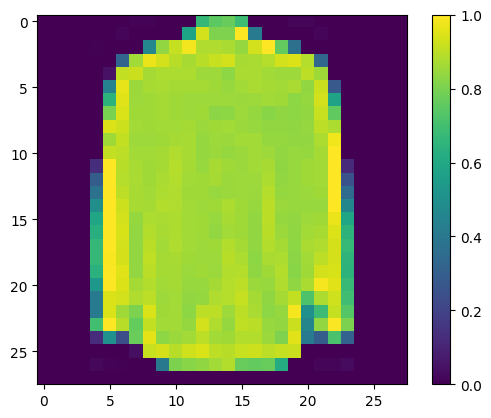

Class: Shirt


In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [27]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2025-07-09 17:32:26--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl


Resolving github.com (github.com)... 

20.87.245.0
Connecting to github.com (github.com)|20.87.245.0|:443... 

connected.


HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2025-07-09 17:32:28--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... 

connected.


HTTP request sent, awaiting response... 

200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

          fasionmni   0%[                    ]       0  --.-KB/s               

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.1s    

2025-07-09 17:32:29 (3.09 MB/s) - ‘fasionmnist_mlp_params.pkl’ saved [407396/407396]



![](../img/e2e_fashionmnist_mlp_model.png)

The above is our model of interest, we can build the PyTorch model as follows.

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [29]:
import pickle as pkl

mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

In [30]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: Shirt


Let us try to translate from fx by defining mapping functions for the corresponding `nn.Module`. Here we are reusing pre-defined TE libraries from TVM `topi` instead of defining our own tensor expression.

- `topi.nn.dense(x, w)` performs transposed matrix multiplication `x @ w.T`
- `topi.add` performs broadcast add.

In [31]:
from tvm import topi


def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)


MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },
)

MLPModule.show()

In [32]:
ex = relax.build(MLPModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Shirt


## Remark: Translating into High-level Operators

In most machine learning frameworks, it is sometimes helpful to first translate into high-level built-in primitive operators. The following code block gives an example to do that.

In [33]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.nn.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    b = map_param(nn_mod.bias)
    return bb.emit(relax.op.linear(x, w, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()

After we get the model into IRModule with those built-in operator calls.
These built-in operators are **higher-level abstraction** than the TensorIR functions. There can be different opportunities to further translate these primitive operators into either library or TensorIR functions.

In most cases, it can be helpful to translate into high-level builtins when they are available. However, there are many cases where we cannot find the corresponding high-level built-in or when we want to specify the TensorIR function directly. In those cases, we can customize the translation logic or transformation to generate `call_dps_packed` or call into the library functions. Usually, we can get the best result by combining the high-level op, TensorIR, and library abstractions. We will discuss the tradeoffs in the follow-up lectures.

## Discussions

In this chapter, we focus on the **develop** part of the MLC flow. We studied different ways to get models from machine learning frameworks onto the IRModule. We also briefly touched upon the high-level primitive operators.

Once we get the model into the IRModule, we can introduce more kinds of transformations on primitive functions and computational graph functions. A good MLC process composes these transformations together to form an end deployment form.

![](../img/mlc_process.png)

## Summary

- Tensor expression API allows us to create a primitive TensorIR function.
- BlockBuilder API creates IRModule through `emit_te` and other functions.
- Integrate with existing machine learning frameworks by transforming models into an IRModule.